# Lab 9 Report: 
## Final Project Codebase

## Project Title: Unraveling Gravitational Ripples: Neural Network Classification

### Group Members: Daniel Fredin & Cole Welch

--------------------

In [1]:
# %matplotlib inline

import numpy as np
import h5py 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField

from scipy import signal
from scipy.fft import fftshift

# Initializes numpy and pytorch random seeds for reproducibility 
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Prepare Data

#### Retreive Dataset

In [2]:
### -------------Load dataset------------- ###

# Define the file name
filename = 'GW3_Transformer.h5'

# Open the file
with h5py.File(filename, 'r') as file:
    # Load the datasets
    bkg_train = np.array(file['bkg_train'])
    bkg_test = np.array(file['bkg_test'])
    signal_train = np.array(file['signal_train'])
    signal_test = np.array(file['signal_test'])

In [3]:
### -------------Label our data as background or signal------------- ###

# Allows us to easily apply labels to our data to denote it as signal or background for classification.
anomaly_class = {
    'Background': 0,
    'Signal': 1
}

# ID our data as background or signal.
bkg_train_ids = np.full(bkg_train.shape[0], anomaly_class['Background'], dtype=int)
bkg_test_ids = np.full(bkg_test.shape[0], anomaly_class['Background'], dtype=int)

signal_train_ids = np.full(signal_train.shape[0], anomaly_class['Signal'], dtype=int)
signal_test_ids = np.full(signal_test.shape[0], anomaly_class['Signal'], dtype=int)

In [4]:
### -------------Merge dataset------------- ###

# Stick our background and signal data together for training and testing.
x_train = np.concatenate((bkg_train, signal_train), axis=0).transpose((0,2,1))
y_train = np.concatenate((bkg_train_ids, signal_train_ids), axis=0)

x_test_data = np.concatenate((bkg_test, signal_test), axis=0).transpose((0,2,1))
y_test = np.concatenate((bkg_test_ids, signal_test_ids), axis=0)

In [5]:
### -------------Shuffle dataset------------- ###

# Shuffle the training data using a randomly chosen permutation. This ensures we don't encounter artifacts from background 
# and signal data being clumped together.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

#### Convert Data to Images

In [6]:
### -------------Split detector dataset------------- ###

# Each 2D dataset of gravitational wave data comes from one of two detectors: 0 (located in Hanford, WA) and 1 
# (located in Livingston, LA). Split the data from these two detectors since we can only pass 2D images into our CNN to train.
x_train_dec1 = x_train[:,:,0]
x_train_dec2 = x_train[:,:,1]

x_test_dec1 = x_test_data[:,:,0]
x_test_dec2 = x_test_data[:,:,1]

In [7]:
### -------------Convert dataset to GASF------------- ###

# Utilize Gramian Angular Fields to transform our image from time series to images so that we can apply a CNN to classify
# them (see https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3 for an explanation of how this works).




# # Scale data with MinMax scaler for input into GASF
# scaler = MinMaxScaler()
# x_train_dec1 = scaler.fit_transform(x_train_dec1)
# x_train_dec2 = scaler.fit_transform(x_train_dec2)

# x_test_dec1 = scaler.fit_transform(x_test_dec1)
# x_test_dec2 = scaler.fit_transform(x_test_dec2)



# gasf = GramianAngularField(image_size=28, method="summation")
# # Convert training data to image format
# img_x_train_dec1 = gasf.fit_transform(x_train_dec1)
# img_x_train_dec2 = gasf.fit_transform(x_train_dec2)

# # Convert testing data to image format
# img_x_test_dec1 = gasf.transform(x_test_dec1)
# img_x_test_dec2 = gasf.transform(x_test_dec2)


# Utilize FFT Spectrograms







# Utilize MarkovTransitionField, which is an alternative to Gramian Angular Fields. We use this to compare with our GASF results. 
# It turns out that this method performs worse (~95% accuracy instead of ~97% with GASF).

# mtf = MarkovTransitionField(image_size=28)
# # Convert training data to image
# img_x_train_dec1 = mtf.fit_transform(x_train_dec1)
# img_x_train_dec2 = mtf.fit_transform(x_train_dec2)

# # Convert testing data to image
# img_x_test_dec1 = mtf.transform(x_test_dec1)
# img_x_test_dec2 = mtf.transform(x_test_dec2)

## TRYING TO GET THIS TO WORK

In [11]:
from gwpy.timeseries import TimeSeries

data_list = []
series_list = []
Sxx_list = []
f_list = []
t_list = []
npseg=67

# datas = [0 ,1, 2, 3]
datas = [x_train_dec1, x_train_dec2, x_test_dec1, x_test_dec2]

for d in range(len(datas)):
    data_list = []
    series_list = []
    Sxx_list = []
    f_list = []
    t_list = []
    npseg=67

    for i in range(len(datas[d])):
        data = (datas[d][i,:])
        data_list.append(data)
        # print(datas[d].shape)
        series = (TimeSeries(data, sample_rate = 4096, unit='s', name='test', t0=0))     #np.array --> constantQ.timeseries   
        series_list.append(series)

        f, t, Sxx = signal.spectrogram(series, fs = 4096, nperseg=npseg, noverlap = npseg-1) #return_onesided = True) 
        Sxx_list.append(Sxx)
        # f_list.append(f)
        # t_list.append(t)
        # print(d)

    if d == 0:
        test_1 = 'test1'
        data_arr_x_train_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec1 = np.asarray(series_list)
        Sxx_arr_x_train_dec1 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_train_dec1 = np.asarray(f_list)
        # t_arr_x_train_dec1 = np.asarray(t_list)
    elif d == 1:
        test_2 = 'test2'
        data_arr_x_train_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_train_dec2 = np.asarray(series_list)
        Sxx_arr_x_train_dec2 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_train_dec2 = np.asarray(f_list)
        # t_arr_x_train_dec2 = np.asarray(t_list)
    elif d == 2:
        test_3 = 'test3'
        data_arr_x_test_dec1 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec1 = np.asarray(series_list)
        Sxx_arr_x_test_dec1 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_test_dec1 = np.asarray(f_list)
        # t_arr_x_test_dec1 = np.asarray(t_list)
    else:
        test_4 = 'test4'
        data_arr_x_test_dec2 = np.stack(data_list, axis = 0)
        series_arr_x_test_dec2 = np.asarray(series_list)
        Sxx_arr_x_test_dec2 = np.stack(Sxx_list, axis = 0)

        # f_arr_x_test_dec2 = np.asarray(f_list)
        # t_arr_x_test_dec2 = np.asarray(t_list)

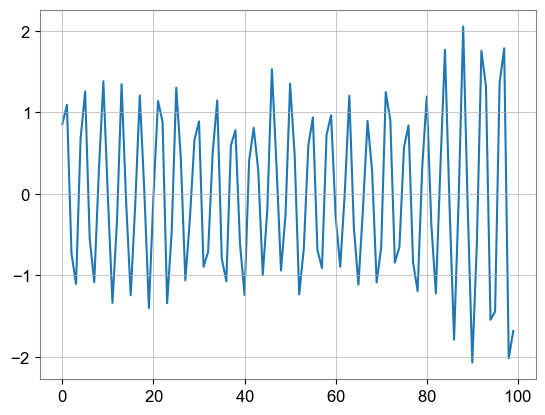

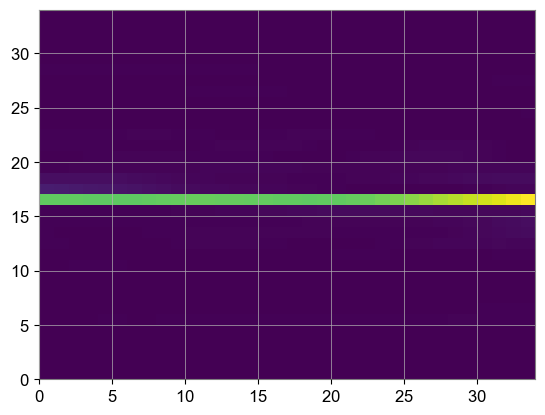

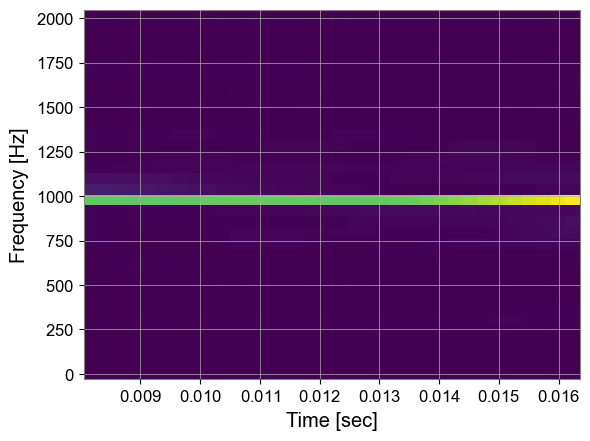

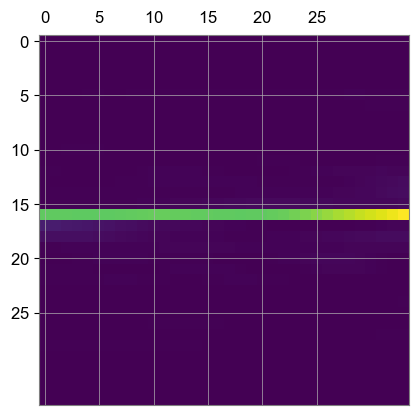

(34, 34)


In [12]:
plt.plot(data_arr_x_train_dec1[4000])
plt.show()

plt.pcolormesh(Sxx_arr_x_train_dec1[4000])
plt.show()

plt.pcolormesh(t, f, Sxx_arr_x_train_dec1[4000])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.imshow(Sxx_arr_x_train_dec1[4000])
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
plt.show()

print(Sxx.shape)

In [ ]:
plt.plot(data_arr[0])
plt.show()

plt.plot(x_train[0,:,0])
plt.show()

plt.plot(bkg_train[41878,0,:])
plt.show()

## THIS WORKS!

In [ ]:
from gwpy.timeseries import TimeSeries
data = x_train_dec1[0,:]

series = TimeSeries(data, sample_rate = 4096, unit='s', name='test', t0=0)     #np.array --> constantQ.timeseries   

npeg=67
f, t, Sxx = signal.spectrogram(series, fs = 4096, nperseg=npeg, noverlap = npeg-1) #return_onesided = True) 



plt.plot(data)
plt.show()

plt.pcolormesh(Sxx)
plt.show()
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.imshow(Sxx)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
plt.show()

print(Sxx.shape)

In [ ]:
series

In [ ]:
# import numpy as np
# from scipy import signal
# from scipy.fft import fftshift
# import matplotlib.pyplot as plt
# rng = np.random.default_rng()

# fs = 10e3
# N = 1e4
# amp = 2 * np.sqrt(2)
# noise_power = 0.01 * fs / 2
# time = np.arange(N) / float(fs)
# mod = 500*np.cos(2*np.pi*0.25*time)
# carrier = amp * np.sin(2*np.pi*3e3*time + mod)
# noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
# noise *= np.exp(-time/5)
# x = carrier + noise
# plt.plot(time, x)
# plt.show()

# f, t, Sxx = signal.spectrogram(x, fs)
# plt.pcolormesh(t, f, Sxx, shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

In [ ]:
plt.plot(x_train_dec1[48000,:])
plt.show()

fs = 100/4096
NFFT=1000

f, t, Sxx = signal.spectrogram(x_train_dec1[48000,:], fs=fs,nperseg=99,scaling='density',mode='psd',nfft=NFFT)
plt.pcolormesh(t, f, Sxx, shading='auto', vmin=Sxx.min(), vmax=Sxx.max())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()	
plt.show()

# Pxx, freqs, bins, im = plt.specgram(x_train_dec1[0,:], NFFT=NFFT, Fs=fs, noverlap=8)
# plt.axis((None, None, 0, 0.5))
# plt.show()

f, t, Sxx = signal.spectrogram(x_train_dec1[48000,:], fs=fs, nfft=NFFT, nperseg=25)
plt.pcolormesh(t, f, Sxx, shading='auto', vmin=Sxx.min(), vmax=Sxx.max())
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()	
plt.show()

plt.imshow(Sxx, aspect='auto', cmap='hot_r', origin='lower')

## GWpy testing

In [ ]:
import numpy as np

# Generate np.array chirp signal
dt = 0.001
t = np.arange(0,3,dt)
f0 = 50
f1 = 250
t1 = 2
x = np.cos(2*np.pi*t*(f0 + (f1 - f0)*np.power(t, 2)/(3*t1**2)))
fs = 1/dt

plt.plot(x)				# plot the chirp signal
plt.show()				# display

In [ ]:
from gwpy.timeseries import TimeSeries
series = TimeSeries(x, dt = 0.001, unit='m', name='test', t0=0)     #np.array --> constantQ.timeseries    

In [ ]:
hdata = series
sq = hdata.q_transform()				# q transform
print(len(sq[0]))       # freq array length
print(len(sq))          # time array length

plt.imshow(sq.T, origin='lower')				# plot the spectrogram
plt.colorbar()									# colorbar
plt.show()										# display

In [ ]:
from scipy import signal as scisignal

freq, ts, Sxx = scisignal.spectrogram(x)		# scipy spectrogram

plt.pcolor(ts, freq, Sxx, shading='auto')		# plot the spectrogram
plt.colorbar()									# colorbar
plt.show()										# display

## experimenting with our data

In [ ]:
len(x_train_dec1[0,:])


In [ ]:
len(x_train_dec1)

In [ ]:
from gwpy.timeseries import TimeSeries
data = x_train_dec1[0,:]

series = TimeSeries(data, sample_rate = 4096, unit='s', name='test', t0=0)     #np.array --> constantQ.timeseries   

npeg=67
f, t, Sxx = signal.spectrogram(series, fs = 4096, nperseg=npeg, noverlap = npeg-1) #return_onesided = True) 



plt.plot(data)
plt.show()

plt.pcolormesh(Sxx)
plt.show()
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.imshow(Sxx)
plt.xticks([0, 5, 10, 15, 20, 25])
plt.yticks([0, 5, 10, 15, 20, 25])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labeltop=True)
plt.show()

print(Sxx.shape)


In [ ]:
plt.plot(series)
q = series.q_transform()
plot = q.plot()
ax = plot.gca()
ax.set_xscale('seconds')

ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()  


In [ ]:
from gwpy.timeseries import TimeSeries
data = x
series = TimeSeries(data, sample_rate = 1, name='test', t0=0)     #np.array --> constantQ.timeseries    

hdata = series
sq = hdata.q_transform(whiten = False, outseg = None)				# q transform
print(len(sq[0]))       # freq array length
print(len(sq))          # time array length

plt.imshow(sq.T, origin='lower')				# plot the spectrogram
plt.colorbar()									# colorbar
plt.show()										# display


from scipy import signal as scisignal

freq, ts, Sxx = scisignal.spectrogram(data)		# scipy spectrogram

plt.pcolor(ts, freq, Sxx, shading='auto')		# plot the spectrogram
plt.colorbar()									# colorbar
plt.show()	

## Real gw data

In [ ]:
from gwpy.timeseries import TimeSeries

data = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)

qspecgram = data.q_transform(outseg=(1126259462.2, 1126259462.5))

plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()


## Testing

In [ ]:
# Generate np.array chirp signal
dt = 0.001
t = np.arange(0,3,dt)
f0 = 50
f1 = 250
t1 = 2
x = np.cos(2*np.pi*t*(f0 + (f1 - f0)*np.power(t, 2)/(3*t1**2)))
fs = 1/dt

plt.plot(x)				# plot the chirp signal
plt.show()				# display

In [ ]:
from gwpy.timeseries import TimeSeries



series = TimeSeries(x, dt = 0.001, unit='m', name='test', t0=0)     #np.array --> constantQ.timeseries   



q = series.q_transform()
plot = q.plot()
ax = plot.gca()
ax.set_xscale('seconds')

ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()